<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Один-нейрон-на-PyTorch" data-toc-modified-id="Один-нейрон-на-PyTorch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><b>Один нейрон на PyTorch</b></a></span><ul class="toc-item"><li><span><a href="#Компоненты-нейросети" data-toc-modified-id="Компоненты-нейросети-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><b>Компоненты нейросети</b></a></span></li><li><span><a href="#Один-нейрон-на-PyTorch" data-toc-modified-id="Один-нейрон-на-PyTorch-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><b>Один нейрон на PyTorch</b></a></span></li><li><span><a href="#Полезные-ссылки" data-toc-modified-id="Полезные-ссылки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><b>Полезные ссылки</b></a></span></li></ul></li></ul></div>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/apples_pears.csv")

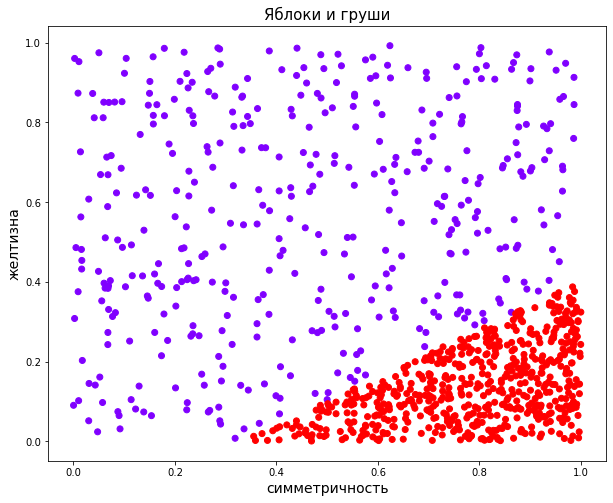

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [4]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [5]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [6]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [7]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [8]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.3797], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

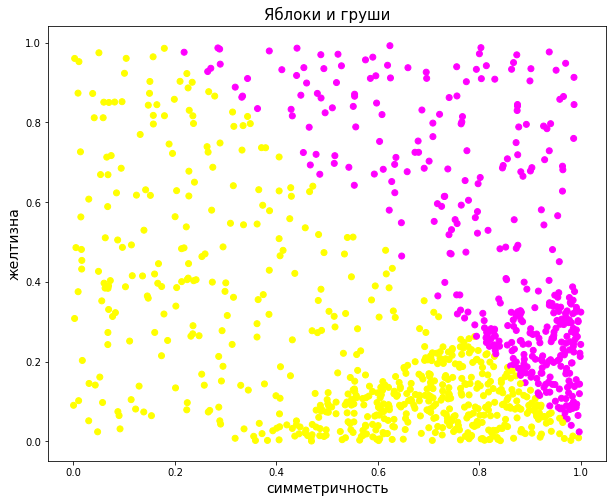

In [9]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [10]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [11]:
# квадратичная функция потерь (можно сделать другую, например, LogLoss)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # обнуляем градиенты перед backard_pass'ом (обязательно!)
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 248.410400390625
1 241.43890380859375
2 235.6521453857422
3 230.6846160888672
4 226.28106689453125
5 222.26968383789062
6 218.537353515625
7 215.01046752929688
8 211.6415557861328
9 208.40017700195312
10 205.26686096191406
11 202.2290802001953
12 199.2787322998047
13 196.41046142578125
14 193.62049865722656
15 190.90618896484375
16 188.26536560058594
17 185.69619750976562
18 183.19696044921875
19 180.76605224609375
20 178.40182495117188
21 176.1027374267578
22 173.8670654296875
23 171.69314575195312
24 169.57933044433594
25 167.52389526367188
26 165.52520751953125
27 163.58151245117188
28 161.6912078857422
29 159.85260009765625
30 158.06405639648438
31 156.32400512695312
32 154.630859375
33 152.98309326171875
34 151.3792266845703
35 149.8177947998047
36 148.29736328125
37 146.81658935546875
38 145.37411499023438
39 143.96868896484375
40 142.59902954101562
41 141.26394653320312
42 139.96226501464844
43 138.69285583496094
44 137.45465087890625
45 136.24659729003906
46 135.0676879882812

Обучили. Предскажем теперь:

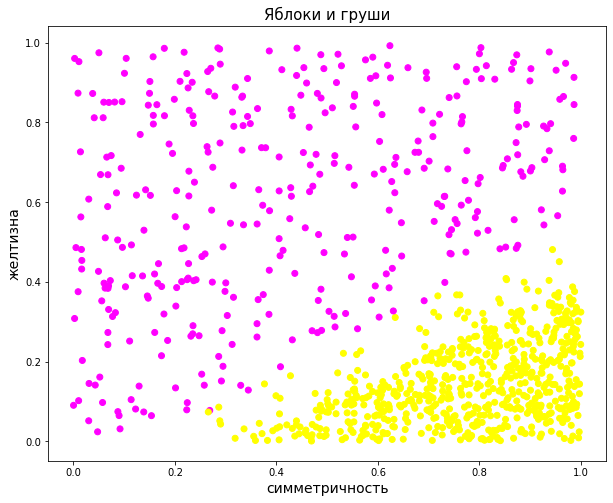

In [12]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()` или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

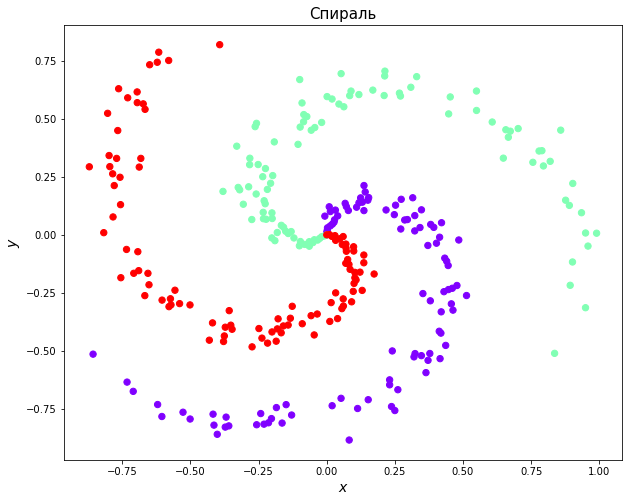

In [13]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable():

In [14]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [15]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем нейрон с сигмоидой на линейно неразделимой выборке (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [16]:
# N - размер батча (batch_size, нужно для метода оптимизации)
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

0 327.122314453125
1 326.8374328613281
2 326.5537414550781
3 326.2712097167969
4 325.98980712890625
5 325.7095642089844
6 325.4304504394531
7 325.1524353027344
8 324.8755798339844
9 324.5998229980469
10 324.3251647949219
11 324.0516662597656
12 323.7791442871094
13 323.5077819824219
14 323.23748779296875
15 322.96826171875
16 322.7000732421875
17 322.4329528808594
18 322.1668701171875
19 321.9018859863281
20 321.6378173828125
21 321.37481689453125
22 321.1129150390625
23 320.8518981933594
24 320.5920104980469
25 320.3330383300781
26 320.0751037597656
27 319.8181457519531
28 319.56219482421875
29 319.30718994140625
30 319.0531921386719
31 318.8001403808594
32 318.54803466796875
33 318.296875
34 318.0466613769531
35 317.7973937988281
36 317.54901123046875
37 317.3016662597656
38 317.05517578125
39 316.8096008300781
40 316.56494140625
41 316.3211975097656
42 316.0783386230469
43 315.8363952636719
44 315.59527587890625
45 315.35516357421875
46 315.11590576171875
47 314.87744140625
48 314.6

In [17]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

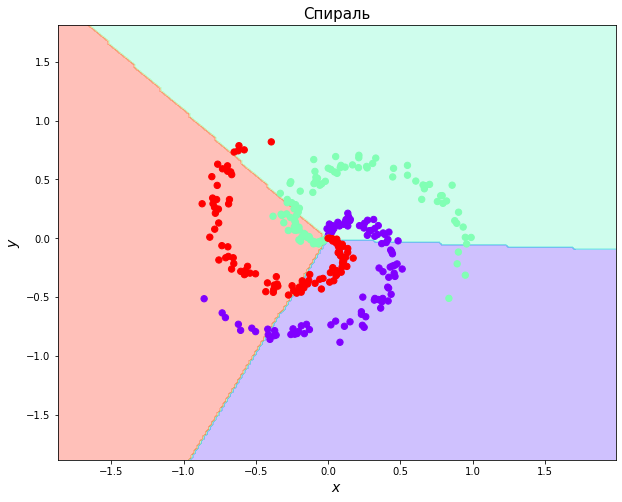

In [18]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слищком впечатляет. В следующей практике мы попробуем многослойную нейросеть на этой же задаче.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*